In [777]:
from openai import OpenAI
import dotenv
import rich
dotenv.load_dotenv('.env')
import mrf
import mrf_data
import tiktoken
import json
import llm
encoding = tiktoken.encoding_for_model('gpt-4o')
from importlib import reload
import torch
import numpy as np
from evaluate import kl_divergence


In [799]:
prompt = {}

prompt['initial_message'] = 'You are a statistician interviewing for a market analytics position. ' +\
                    'During the interview, you are asked to analyze the nightly prices of Airbnb listings in the United States in 2017. ' +\
                    'Although you do not have access to any actual data, you are known for your ability to identify structures and relationships among data variables using intuition and commonsense guesses.\n' 



prompt['default'] = 'The interviewer will guide your thinking through a set of predefined questions. ' +\
                    '\nUse Intuition: Since there is no data to fit to, rely on intuition and commonsense knowledge to make broad generalizations. ' +\
                    '\nVariable Selection: Consider only the most relevant variables and restrict the number of variables and their possible values to cover likely circumstances.' +\
                    '\nReasoning First: Think and reason through the problem concisely before providing structured answers. Avoid giving explanations after your answers.'



prompt['zero'] = "First understand the problem and devise a plan to solve the problem. Then, carry out the plan and solve the problem step-by-step."



json_dialogue = []

system = 'You are a transcriber tasked to convert parts of a statistician interview for a market analytics position into JSON and provide querying messages. ' +\
        'During the interview, the interviewee was asked to analyze the nightly prices of Airbnb listings in the United States in 2017. '

system += 'The JSON record has two parts, Variables and Constraints. Constraints can be left out if not mentioned yet. \nVariables define the variable names and their possible values. You should try to simplify the names if possible for convenience, but make sure to keep the naming consistent. For example, Variable X with Values x1, x2, and x3. \n\nEach constraint entry has three parts: (Batch) Target, Condition, and (Batch) Probability. Target an Condition also consist of names and possible values. Probability denotes conditional or unconditional probabilities in interval or number. \nFor example, if there is P(Y=y1|X=x1)=0.9, then Target has Variable Y with Value y1, and Condition Variable X Value x1, and a probability of 0.9. \nIf there are multiple conditions in the value, then we are conditioning on the collection of them: P(Y=y1|X=x1 or X=x2) then Condition has Variable X Value x1, x2.\nThere can also be no conditions, like P(X=x1), and then Condition is left empty.\n For simplicity, we also have Batch notation:\nIf conditioned on x1 probability of y1 is 0.7 and of y2 is 40%-50%, then we use BatchTarget with Name Y and Values y1, y2. In this case there is BatchProbability which must has two entries, 0.7 and [0.4, 0.5].\n When transcribing for records, always provide the existing Variables, but provide only the latest constraints (exclude constraints from previous dialogues). \n There would also be query to the record, in which case you should provide a format similar to the records. The question may have slightly different wording, but you are to provide a query JSON appropriate to the question to the extent allowed by the Variable defitions, without making additional assumptions. \nAfter the initial training warmup (with hints), you will start converting the actual dialogue. Remember that the warmup is only to provide examples. Generate JSON without line breaks or extra white spaces.'

json_dialogue.append({"role": "system", "content": system})

# put comments in JSON
user_1 = '[warmup][record] After consideration, I think there should be three variables: \nA with values a1, a2, a3\n B with values b1, b2\n C with values c1, c2. \n'
#user_1 += '[required] ' + '{"Variables": [{"Name": "A"}, {"Name": "C", "Value": ["c2"]}]}'
#user_1 += ' (must include these variables with exact naming)'

assistant_1 = '\n{\n  "Variables": [\n    {\n      "Name": "A",\n      "Value": ["a1", "a2", "a3"]\n    },\n    {\n      "Name": "B",\n      "Value": ["b1", "b2"]\n    },\n    {\n      "Name": "C",\n      "Value": ["c1", "c2"]\n    }\n  ]}'


print("assistant 1 before stripping: ", len(encoding.encode(assistant_1)))
assistant_1 = assistant_1.replace('\n', '')
assistant_1 = assistant_1.replace(' ', '')
print("assistant 1 after stripping: ", len(encoding.encode(assistant_1)))


json_dialogue.append({"role": "user", "content": user_1})
json_dialogue.append({"role": "assistant", "content": assistant_1})


user_2 = '[warmup][record] Conditional probability of a1 given b2: 10%-20%\n' +\
    '(0.1<P(A=a1|B=b2)<0.2)\n\n' +\
    'Conditional probability of c2 given a1 or a2: 50% \n' +\
    '(P(C=c2|A=a1 or A=a2)=0.5)\n\n'


assistant_2 = '\n{\n  "Variables": [\n    {\n      "Name": "A",\n      "Value": ["a1", "a2", "a3"]\n    },\n    {\n      "Name": "B",\n      "Value": ["b1", "b2"]\n    },\n    {\n      "Name": "C",\n      "Value": ["c1", "c2"]\n    }\n  ],\n  "Constraints": [\n    {\n      "Target": [\n        {\n          "Name": "A",\n          "Value": ["a1"]\n        }\n      ],\n      "Condition": [\n        {\n          "Name": "B",\n          "Value": ["b2"]\n        },\n      ],\n      "Probability": [0.1, 0.2]\n    },\n    {\n      "Target": [\n        {\n          "Name": "C",\n          "Value": ["c2"]\n        }\n      ],\n      "Condition": [\n        {\n          "Name": "A",\n          "Value": ["a1", "a2"]\n        }\n      ],\n      "Probability": [0.5]\n    }\n  ]\n}'


print("assistant 2 before stripping: ", len(encoding.encode(assistant_2)))
assistant_2 = assistant_2.replace('\n', '')
assistant_2 = assistant_2.replace(' ', '')
print("assistant 2 after stripping: ", len(encoding.encode(assistant_2)))


json_dialogue.append({"role": "user", "content": user_2})
json_dialogue.append({"role": "assistant", "content": assistant_2})


user_3 = '[warmup][record] Marginal probability of a2: 0.8-0.9\n' +\
    '(0.8<P(A=a2)<0.9)\n\n' + \
    'C=c2:\n' +\
    'b1: 30%-40%, b2: 60% (in this case we use Batch for simplicity, as multiple probabilities of Variable B conditioned on c2 is given)\n' +\
    '(0.3<P(B=b1|C=c2)<0.4, P(B=b2|C=c2)=0.6)\n\n'

assistant_3 = '\n{\n  "Variables": [\n    {\n      "Name": "A",\n      "Value": ["a1", "a2", "a3"]\n    },\n    {\n      "Name": "B",\n      "Value": ["b1", "b2"]\n    },\n    {\n      "Name": "C",\n      "Value": ["c1", "c2"]\n    }\n  ],\n  "Constraints": [\n    {\n      "Target": [\n        {\n          "Name": "A",\n          "Value": ["a2"]\n        }\n      ],\n      "Condition": [],\n      "Probability": [0.8, 0.9]\n    },\n    {\n      "Batch Target": [\n        {\n          "Name": "B",\n          "Value": ["b1", "b2"]\n        }\n      ],\n      "Condition": [\n        {\n          "Name": "C",\n          "Value": ["c2"]\n        }\n      ],\n      "Batch Probability": [\n        [0.3, 0.4],\n        [0.6]\n      ]\n    }\n  ]\n}'


print("assistant 3 before stripping: ", len(encoding.encode(assistant_3)))
assistant_3 = assistant_3.replace('\n', '')
assistant_3 = assistant_3.replace(' ', '')
print("assistant 3 after stripping: ", len(encoding.encode(assistant_3)))


json_dialogue.append({"role": "user", "content": user_3})
json_dialogue.append({"role": "assistant", "content": assistant_3})


user_4 = '[warmup][query] What is Beta is we know that A is at most 2? (Beta would be a different way to refer to B in our Variable, and since a specific value is not provided, we perform a batch target query on B with all possible values of B)'
assistant_4 = '\n{\n  "Queries": [\n    {\n      "Batch Target": [\n        {\n          "Name": "B",\n          "Value": ["b1", "b2"]\n        }\n      ],\n      "Condition": [\n        {\n          "Name": "A",\n          "Value": ["a1", "a2"]\n        }\n      ]\n    }\n  ]\n}'



print("assistant 4 before stripping: ", len(encoding.encode(assistant_4)))
assistant_4 = assistant_4.replace('\n', '')
assistant_4 = assistant_4.replace(' ', '')
print("assistant 4 after stripping: ", len(encoding.encode(assistant_4)))


json_dialogue.append({"role": "user", "content": user_4})
json_dialogue.append({"role": "assistant", "content": assistant_4})


prompt['json_dialogue'] = json_dialogue


prompt['binq'] = 'To model the nightly price of Airbnb listings in 2017, we need to first divide the price into a few ranges. Think about the appropriate parametric distribution to approximate the price. Divide the price into 4~5 ranges accordingly. This would be our first variable.'

# Reason through how these variables might interact or correlate with each other. 
prompt['brainq'] = "Let's brainstorm the variables that might affect or determine the prices of Airbnb listings. Think about the commonsense intrinsic or extrinsic factors that would influence pricing. "

prompt['broadq'] = "Identify key interactions among the variables. Consider how they might interact with or correlate to each other. For example, how many bedrooms do entire house listings tend to offer? You can suggest new relevant variables if necessary."


prompt['moreq'] = "Take your time to reason through additional variables and their possible interactions. Consider other factors that might influence the price, or other existing variables."

prompt['varq'] = "Select a few key variables (fewer than 7), including but not limited to price. For each variable, exhaustively list all possible values, ensuring they are concrete and mutually exclusive. Focus on variables that reveal meaningful patterns or relationships, not just their impact on price."

prompt['condq'] = "You should provide an updated response based on this new consideration. "

# p(x)  You can give a credible interval if unsure.
prompt['margq'] = "Estimate the marginal probabilities for the values of each variable based on your best intuition. Give a best guess."

# p(price|bedroom)
prompt['pricecondq'] = 'How would they affect the price? Suggest the numeric probability of price, conditioned on each of these variable values. Give a best guess. However, if you think that the variable or value does not affect the price much, you can skip it.'

# p(bedroom=2|property_type=entire_house)
#interactq = "How do you think the rest of the chosen variables interact with each other? Avoid duplicates from before. After reasoning through, suggest the conditional probability that captures those interaction."
# dependencies <-> interaction? point-wise mutual information 
prompt['interactq'] = "What are some dependencies among these variables other than price? Suggest numeric conditional probability that captures those interaction. "

prompt['freebins'] = " Divide the prices into a few ranges as you see fit. "

prompt['bins'] = "Price Range: $0 - $50, $51 - $100, $101 - $200, $201 - $400, $401 and above"


prompt['getprob'] = "Translate the probability given into JSON. Only give the probability of the final answer. For example, if given probabilities 0.1, 0.2, 0.4, return a JSON:\n" +\
                    '{"Probability": [0.1, 0.2, 0.4]}'





# save prompt
with open('./prompt.json', 'w') as file:
    json.dump(prompt, file)


chains = ['binq', 'brainq', 'broadq', 'varq']
saws = [None, 'margq', 'pricecondq', 'interactq']

seq = [chains, saws]

with open('./example_question.json', 'r') as file:
    question = json.load(file)

assistant 1 before stripping:  83
assistant 1 after stripping:  47
assistant 2 before stripping:  229
assistant 2 after stripping:  127
assistant 3 before stripping:  225
assistant 3 after stripping:  128
assistant 4 before stripping:  75
assistant 4 after stripping:  40


In [800]:
import importlib
importlib.reload(llm)
#agent = llm.LLM(initial_message, model='gpt-3.5-turbo', json_format=formatq)
agent = llm.LLM(question=question, sequences=seq)
#agent = llm.LLM(question=question, model='gpt-3.5-turbo')
agent.reset()

Modified variable question:  Select a few key variables (fewer than 7), including but not limited to price. For each variable, exhaustively list all possible values, ensuring they are concrete and mutually exclusive. Focus on variables that reveal meaningful patterns or relationships, not just their impact on price.
Additionally without loss of generality, we would like to be able to answer questions such as: What is the nightly price of a aribnb listing that is a private room in a property with at most 3 beds?
Make sure that the updated variables can express such questions with existing variables. 


In [801]:
zero_ret = agent.get_zero()

user : What is the nightly price of a aribnb listing that is a private room in a property with at most 3 beds?
Price Range: $0 - $50, $51 - $100, $101 - $200, $201 - $400, $401 and above
Provide the probability of each bin for the variable price. Give a definite value, not a range.


--------------------------------------------------------------------------------------


assistant : ### Understanding the Problem

The problem requires us to estimate the distribution of nightly prices for Airbnb listings in the United States in 2017, specifically for private rooms in properties with at most 3 beds. We need to provide the probability of each price range bin:

1. $0 - $50
2. $51 - $100
3. $101 - $200
4. $201 - $400
5. $401 and above

### Devising a Plan

1. **Understand the Market Context**: Airbnb listings vary widely based on location, type of accommodation, amenities, and other factors. Private rooms tend to be cheaper than entire homes or apartments.
2. **Consider Typical Pricing**: Fo

array([0.1 , 0.5 , 0.3 , 0.08, 0.02])

In [797]:
cot_ret = agent.get_cot()

user : To model the nightly price of Airbnb listings in 2017, we need to first divide the price into a few ranges. Think about the appropriate parametric distribution to approximate the price. Divide the price into 4~5 ranges accordingly. This would be our first variable.


--------------------------------------------------------------------------------------


assistant : Given the nature of Airbnb listings, the nightly prices are likely to follow a right-skewed distribution, such as a log-normal distribution, where most listings are clustered at lower prices with a long tail of higher-priced listings. Based on this, I would divide the nightly price into the following ranges:

1. $0 - $50
2. $51 - $100
3. $101 - $200
4. $201 - $400
5. $401 and above


--------------------------------------------------------------------------------------


user : Let's brainstorm the variables that might affect or determine the prices of Airbnb listings. Think about the commonsense intrinsic or extrins

array([0.3  , 0.475, 0.19 , 0.06 , 0.   ])

In [558]:
cur_j, query = agent.button()

user : To model the nightly price of Airbnb listings in 2017, we need to first divide the price into a few ranges. Think about the appropriate parametric distribution to approximate the price. Divide the price into 4~5 ranges accordingly. This would be our first variable.


--------------------------------------------------------------------------------------


assistant : The nightly price of Airbnb listings can be approximated using a log-normal distribution, as prices are typically skewed with a long tail on the right. Based on this, we can divide the price into the following ranges:

1. $0 - $50
2. $51 - $100
3. $101 - $200
4. $201 - $500
5. $501 and above


--------------------------------------------------------------------------------------


user : Let's brainstorm the variables that might affect or determine the prices of Airbnb listings. Think about the commonsense intrinsic or extrinsic factors that would influence pricing. 


------------------------------------------------

In [805]:
reload(mrf_data)
dat = mrf_data.data()
#dat.set_bins([50, 100, 150, 300, 500])
dat.set_bins([50, 100, 200, 400])
cond = lambda x: x[(x['room_type'] == 'Private room') & (x['beds'] <= 3)]
ground = dat.marg(cond=cond)
ground = torch.tensor(ground)
print(kl_divergence(ground, cot_ret))
print(kl_divergence(ground, zero_ret))

All columns available:  Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds',
       'price'],
      dtype='object')
Columns used:  ['log_price', 'bathrooms', 'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'amenities', 'review_scores_rating', 'city']
-1 - 50: 	22.24%
50 - 100: 	57.95%
100 - 200: 	16.96%
200 - 400: 	2.15%
400 - 1999: 	0.70%
tensor(0.0048, dtype=torch.float64)
tensor(0.1308, dtype=torch.float64)


In [739]:
reload(mrf)


# guidance package?
vars = agent.var_json
constraints_list = agent.cons_json
test = mrf.Brute()
#build_ret = test.from_json(vars=vars, constraints=constraints_list)
build_ret = test.from_json(entire_json=agent.current_json)
test.update(10000)


Variable:  Price Range
Value:  $0 - $50, $51 - $100, $101 - $200, $201 - $500, $501 and above 


Variable:  Property Type
Value:  Entire Home/Apartment, Private Room, Shared Room 


Variable:  Number of Beds
Value:  1 Bed, 2 Beds, 3 Beds, 4+ Beds 


Variable:  Location
Value:  Urban, Suburban, Rural 


Variable:  Amenities
Value:  Basic, Premium, Luxury 


Variable:  Season
Value:  Peak Season, Off-Peak Season 

-----------------------------------------------
Finished building
Features:  132
Constraints:  131
-----------------------------------------------


  0%|          | 0/10000 [00:00<?, ?it/s]

Loss:  tensor(15.2354, grad_fn=<SumBackward0>) tensor(0.1163, grad_fn=<MeanBackward0>)


 22%|██▏       | 2242/10000 [00:01<00:03, 2244.23it/s]

Loss:  tensor(0.0939, grad_fn=<SumBackward0>) tensor(0.0007, grad_fn=<MeanBackward0>)


 44%|████▎     | 4360/10000 [00:02<00:02, 2244.17it/s]

Loss:  tensor(0.0781, grad_fn=<SumBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)


 62%|██████▏   | 6243/10000 [00:03<00:01, 1940.64it/s]

Loss:  tensor(0.0751, grad_fn=<SumBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)


 82%|████████▏ | 8221/10000 [00:04<00:01, 1696.27it/s]

Loss:  tensor(0.0739, grad_fn=<SumBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)


100%|██████████| 10000/10000 [00:05<00:00, 1768.53it/s]

Loss:  tensor(0.0732, grad_fn=<SumBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>)


In [626]:
query = agent.query_q
if type(query) == str:
    query = json.loads(query)

#query['Queries'][0]['Condition'].append({'Name': 'Location', 'Value': ['Urban']})

print(query)
res = test.query(query)
print(res)
print(kl_divergence(ground, res))


{'Queries': [{'BatchTarget': [{'Name': 'Price Range', 'Value': ['$0 - $50', '$51 - $100', '$101 - $200', '$201 - $500', '$501 and above']}], 'Condition': [{'Name': 'Property Type', 'Value': ['Private Room']}, {'Name': 'Number of Beds', 'Value': ['1 Bed', '2 Beds', '3 Beds']}]}]}
[{'Name': 'Property Type', 'Value': ['Private Room']}, {'Name': 'Number of Beds', 'Value': ['1 Bed', '2 Beds', '3 Beds']}]
tensor([0.1976, 0.4914, 0.2517, 0.0463, 0.0131])
tensor(0.0343, dtype=torch.float64)


In [625]:
query = agent.query_q
if type(query) == str:
    query = json.loads(query)
#query['Queries'][0]['Condition'].append({'Name': 'Location', 'Value': ['Urban']})
#query['Queries'][0]['Condition'] = []
print(query)
res = test.query(query)
print(res)
print(kl_divergence(ground, torch.tensor([0.05, 0.35, 0.4, 0.18, 0.02])))


{'Queries': [{'BatchTarget': [{'Name': 'Price Range', 'Value': ['$0 - $50', '$51 - $100', '$101 - $200', '$201 - $500', '$501 and above']}], 'Condition': [{'Name': 'Property Type', 'Value': ['Private Room']}, {'Name': 'Number of Beds', 'Value': ['1 Bed', '2 Beds', '3 Beds']}]}]}
[{'Name': 'Property Type', 'Value': ['Private Room']}, {'Name': 'Number of Beds', 'Value': ['1 Bed', '2 Beds', '3 Beds']}]
tensor([0.1976, 0.4914, 0.2517, 0.0463, 0.0131])
tensor(0.4235, dtype=torch.float64)


In [404]:
que = query.copy()
que['Queries'][0]['Batch Target'] = [{'Name': 'Price'}]
que['Queries'][0]['Condition'] = [{'Name': 'Property Type', 'Value': ['Private Room']}, {'Name': 'Number of Beds', 'Value': ['1 Bed']}]
print(test.query(que))

[{'Name': 'Property Type', 'Value': ['Private Room']}, {'Name': 'Number of Beds', 'Value': ['1 Bed']}]
tensor([0.1718, 0.3613, 0.2856, 0.1082, 0.0412, 0.0318])


In [396]:
que = query.copy()
que['Queries'][0]['Batch Target'] = [{'Name': 'Number of Beds'}]
que['Queries'][0]['Condition'] = [{'Name': 'Property Type', 'Value': ['Private Room']}]
print(test.query(que))

[{'Name': 'Property Type', 'Value': ['Private Room']}]
tensor([0.5706, 0.3243, 0.0835, 0.0215])


In [585]:
dat = mrf_data.data()
ret = dat.dat['price'].tolist()

All columns available:  Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds',
       'price'],
      dtype='object')
Columns used:  ['log_price', 'bathrooms', 'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'amenities', 'review_scores_rating', 'city']


0.9061288972704796 0.0 134.1539393754442


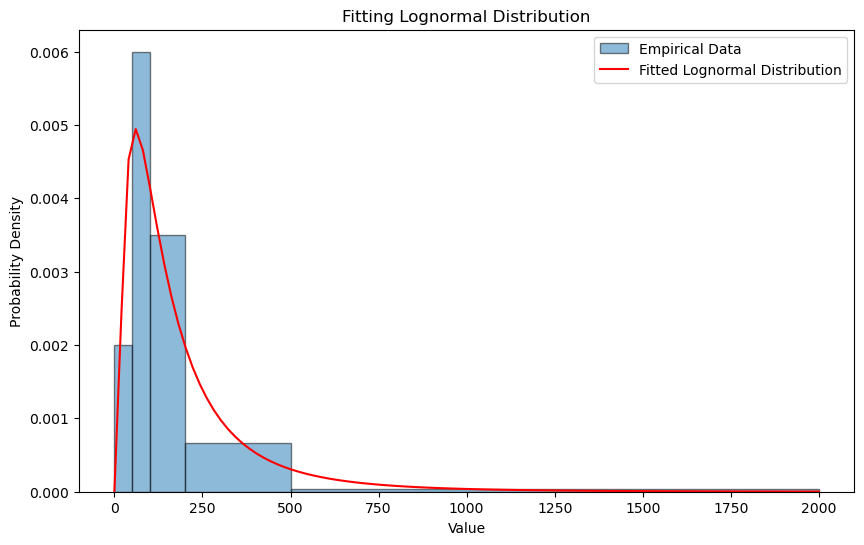

In [685]:
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt

# Example probability bins for a log-normal distribution
# Replace these with your actual probability bins and edges
bins = np.array([0.1, 0.3, 0.35, 0.2, 0.05])
bin_edges = np.array([0, 50, 100, 200, 500, 2000])

# Calculate the bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Scale the bins to ensure integer counts for np.repeat
scale_factor = 1000
counts = (bins * scale_factor).astype(int)

# Create a dataset from the bin centers weighted by the bin frequencies
data = np.repeat(bin_centers, counts)

# Fit a lognormal distribution to the data
shape, loc, scale = lognorm.fit(data, floc=0)

# Create a range of values to plot the fitted lognormal distribution
x = np.linspace(min(bin_edges), max(bin_edges), 100)
pdf_lognormal = lognorm.pdf(x, s=shape, loc=loc, scale=scale)

print(shape, loc, scale)

# Plot the distributions
plt.figure(figsize=(10, 6))
plt.hist(bin_centers, bins=bin_edges, weights=bins, alpha=0.5, label='Empirical Data', edgecolor='k', density=True)
plt.plot(x, pdf_lognormal, 'r-', label='Fitted Lognormal Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Fitting Lognormal Distribution')
plt.legend()
plt.show()


127.19822200065063 1.0306201165450188
4.763866706384924 0.6806201165450189
Mean of the fitted lognormal distribution: 147.7451127504221
Variance of the fitted lognormal distribution: 12861.872833998757
New bin probabilities: [0.10721 0.3037  0.37218 0.20035 0.01654]


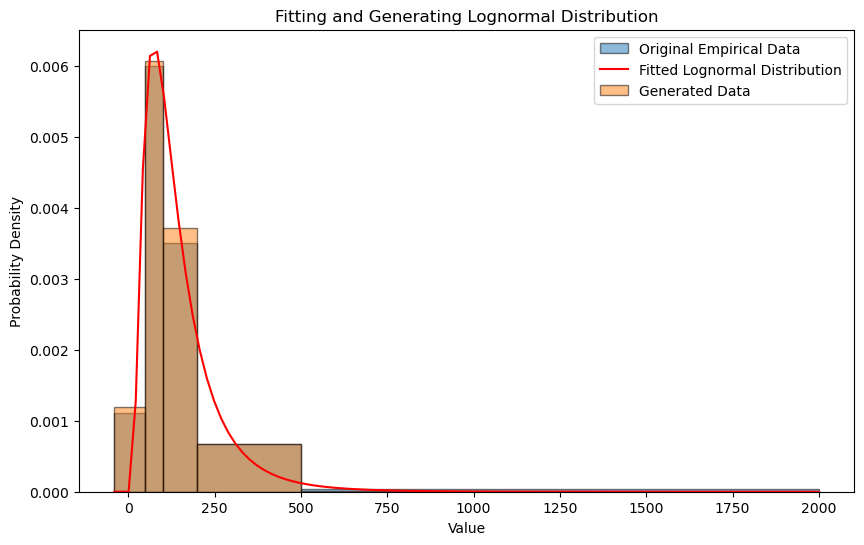

In [733]:
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt

# Example probability bins for a log-normal distribution
# Replace these with your actual probability bins and edges

#bins = np.array([0.1976, 0.4914, 0.2517, 0.0463, 0.0131])
bins = np.array([0.1, 0.3, 0.35, 0.2, 0.05])

bin_edges = np.array([1e-10, 50, 100, 200, 500, 2000])


#assume each bin go in linear
data = []
for i in range(len(bin_centers)):
    data += np.linspace(bin_edges[i], bin_edges[i+1], int(bins[i]*100000)).tolist()


# Calculate the bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Scale the bins to ensure integer counts for np.repeat
scale_factor = 1000
counts = (bins * scale_factor).astype(int)

# Create a dataset from the bin centers weighted by the bin frequencies
#data = np.repeat(bin_centers, counts)


#print(data)

# Fit a lognormal distribution to the data
shape, loc, scale = lognorm.fit(data, floc=0)
print(scale, shape)
scale -= 10
shape -= 0.35


# Calculate mean and variance of the fitted lognormal distribution
mu = np.log(scale)
sigma = shape
print(mu, sigma)


mean = np.exp(mu + (sigma**2) / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)

print(f"Mean of the fitted lognormal distribution: {mean}")
print(f"Variance of the fitted lognormal distribution: {variance}")

# Generate new data from the fitted lognormal distribution
num_samples = 100000
generated_data = lognorm.rvs(s=shape, loc=loc, scale=scale, size=num_samples)



bin_edges = np.array([-40, 50, 100, 200, 500, 2000])

# Calculate the new bin probabilities
new_bin_counts, _ = np.histogram(generated_data, bins=bin_edges)
new_bin_probabilities = new_bin_counts / num_samples

print(f"New bin probabilities: {new_bin_probabilities}")

# Create a range of values to plot the fitted lognormal distribution
x = np.linspace(min(bin_edges), max(bin_edges), 100)
pdf_lognormal = lognorm.pdf(x, s=shape, loc=loc, scale=scale)

# Plot the distributions
plt.figure(figsize=(10, 6))
plt.hist(bin_centers, bins=bin_edges, weights=bins, alpha=0.5, label='Original Empirical Data', edgecolor='k', density=True)
plt.plot(x, pdf_lognormal, 'r-', label='Fitted Lognormal Distribution')
plt.hist(generated_data, bins=bin_edges, alpha=0.5, label='Generated Data', edgecolor='k', density=True)
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Fitting and Generating Lognormal Distribution')
plt.legend()
plt.show()


In [ ]:
# pickle
import pickle

with open('vars.pkl', 'wb') as f:
    pickle.dump(agent.var_json, f)
with open('cons.pkl', 'wb') as f:
    pickle.dump(agent.cons_json, f)
with open('current_json.pkl', 'wb') as f:
    pickle.dump(agent.current_json, f)
with open('query.pkl', 'wb') as f:
    pickle.dump(query, f)


In [ ]:
# load pickle
import pickle

with open('vars.pkl', 'rb') as f:
    vars = pickle.load(f)
with open('cons.pkl', 'rb') as f:
    constraints_list = pickle.load(f)
with open('current_json.pkl', 'rb') as f:
    current_json = pickle.load(f)
with open('query.pkl', 'rb') as f:
    query = pickle.load(f)